In [26]:
# Package used for loading data from the input text file
from numpy import loadtxt

# biosignalsnotebooks python package
import biosignalsnotebooks as bsnb
import biosignalsnotebooks.signal_samples as bsnb_ss
# Scientific packages
from numpy import linspace, where
from scipy.signal import periodogram
from scipy.integrate import cumtrapz

# Scientific packages
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax
from scipy.integrate import cumtrapz
from scipy.signal import welch
 #Package dedicated to process Python abstract syntax grammar Abstract 
# (Abstract Syntax Trees)
from ast import literal_eval

# Package used for accessing .h5 file contents
from h5py import File
# Numpy package is dedicated to simplify the work (operations between) with arrays/lists
from numpy import cumsum, concatenate, zeros, linspace, average, power, absolute, mean, std, max, array, diff, where

# Scientific packages
from scipy.signal import butter, lfilter
from scipy.stats import linregress







In [66]:
import biosignalsnotebooks as bsnb

# Numpy package is dedicated to simplify the work (operations between) with arrays/lists
from numpy import cumsum, concatenate, zeros, linspace, average, power, absolute, mean, std, max, array, diff, where

# Scientific packages
from scipy.signal import butter, lfilter
from scipy.stats import linregress

import pandas as pd
import numpy as np
from numpy.random import choice, randint
import matplotlib.pyplot as plt


import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

cred = credentials.Certificate('D:/oct 2020 exam/muscle-imbalance-detection-firebase-adminsdk-cdpnd-144c53d23b.json')
app = firebase_admin.initialize_app(cred)
db = firestore.client()

In [ ]:
devs = db.collection('measurements')


docs = devs.get()
data = []
for doc in docs:
    data.append(doc.to_dict())
    df = pd.DataFrame(data)
    #df=df.astype(float)
    
df.to_csv('SampleEMGG.csv', index=False)

In [ ]:
df = pd.read_csv('SampleEMGG.csv')
print(df)
print(df['visualRepresentationSensorOne'].dtypes)
df.to_hdf(df, 'SampleEMGG', mode='w', format='table')



In [67]:
# [Baseline Removal]
pre_pro_signal = signal - average(signal)

# [Signal Filtering]
low_cutoff = 10 # Hz
high_cutoff = 300 # Hz

# Application of the signal to the filter.
pre_pro_signal = bsnb.aux_functions._butter_bandpass_filter(pre_pro_signal, low_cutoff, high_cutoff, sr)

In [68]:
# [Application of TKEO Operator]
tkeo = []
for i in range(0, len(pre_pro_signal)):
    if i == 0 or i == len(pre_pro_signal) - 1:
        tkeo.append(pre_pro_signal[i])
    else:
        tkeo.append(power(pre_pro_signal[i], 2) - (pre_pro_signal[i + 1] * pre_pro_signal[i - 1]))

In [69]:
# Smoothing level [Size of sliding window used during the moving average process (a function of sampling frequency)]
smoothing_level_perc = 20 # Percentage.
smoothing_level = int((smoothing_level_perc / 100) * sr)
print(smoothing_level)

200


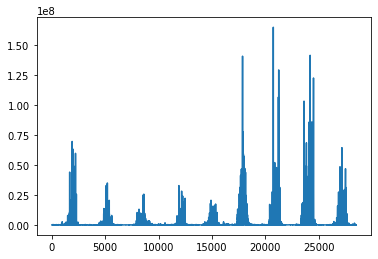

In [70]:
# [Signal Rectification]
import matplotlib.pyplot as plt
rect_signal = absolute(tkeo)
plt.plot(rect_signal)
plt.show()

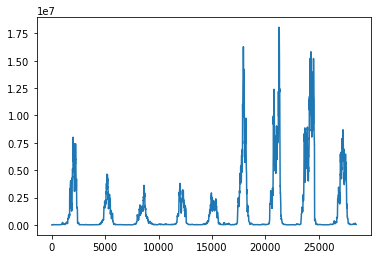

In [71]:
# [First Moving Average Filter]
rect_signal = bsnb.aux_functions._moving_average(rect_signal, sr / 10)
plt.plot(rect_signal)
plt.show()

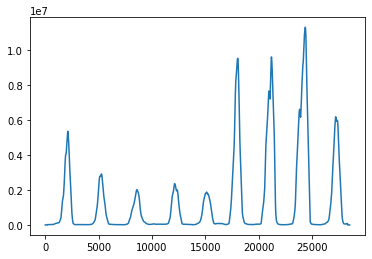

In [89]:
# [Second Smoothing Phase]
smooth_signal = []
for i in range(0, len(rect_signal)):
    if smoothing_level < i < len(rect_signal) - smoothing_level:
        smooth_signal.append(mean(rect_signal[i - smoothing_level:i + smoothing_level]))
    else:
        smooth_signal.append(0)
plt.plot(smooth_signal)


plt.show()

In [73]:
# [Threshold]
avg_pre_pro_signal = average(pre_pro_signal)
std_pre_pro_signal = std(pre_pro_signal)


In [74]:
# Regression function.
def normReg(thresholdLevel):
    threshold_0_perc_level = (- avg_pre_pro_signal) / float(std_pre_pro_signal)
    threshold_100_perc_level = (max(smooth_signal) - avg_pre_pro_signal) / float(std_pre_pro_signal)
    m, b = linregress([0, 100], [threshold_0_perc_level, threshold_100_perc_level])[:2]
    return m * thresholdLevel + b 

In [94]:
# Chosen Threshold Level (Example with two extreme values)
threshold_level = 10 # % Relative to the average value of the smoothed signal
threshold_level_norm_10 = normReg(threshold_level)

threshold_level = 80 # % Relative to the average value of the smoothed signal
threshold_level_norm_80 = normReg(threshold_level)

threshold_10 = avg_pre_pro_signal + threshold_level_norm_10 * std_pre_pro_signal
threshold_80 = avg_pre_pro_signal + threshold_level_norm_80 * std_pre_pro_signal


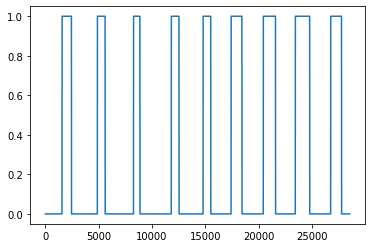

In [76]:
# Generation of a square wave reflecting the activation and inactivation periods.
binary_signal = []
for i in range(0, len(time)):
    if smooth_signal[i] >= threshold_10:
        binary_signal.append(1)
    else:
        binary_signal.append(0)
plt.plot(binary_signal)
plt.show()

In [77]:
diff_signal = diff(binary_signal)
act_begin = where(diff_signal == 1)[0]
act_end = where(diff_signal == -1)[0]

In [81]:
activation_data = bsnb.detect_emg_activations(signal, sr, smooth_level=20, threshold_level=10, time_units=True, volts=False, resolution=None, device=device, plot_result=True)

In [ ]:
# 

In [ ]:
# Specification of the file path 
# (in our case is a relative file path but an absolute one can be specified)
relative_file_path = "D:/medical enff project course/SampleEMGG.h5"

# Creation of h5py object
file_h5 = File(relative_file_path)

In [48]:
available_keys = list(file_h5.keys())
mac = available_keys[0]
group_lv1 = file_h5.get(mac)
attrs_lv1 = group_lv1.attrs.items()
header_h5 = dict(attrs_lv1)

In [50]:
# Specification of the file path (in our case is a relative file path but an absolute one can be specified)
relative_file_path = "D:/medical enff project course/SampleEMGG.h5"

data, header = bsnb.load(relative_file_path, get_header=True)

In [51]:
channel = list(data.keys())[0]
device = header["device"]
resolution = int(header["resolution"][0])

In [52]:
fs = header["sampling rate"]

# Signal Samples
signal = bsnb.raw_to_phy("EMG", device, data[channel], resolution, option="mV") # Conversion to mV
time = linspace(0, len(signal) / fs, len(signal))

In [53]:
burst_begin, burst_end = bsnb.detect_emg_activations(signal, fs, smooth_level=20, threshold_level=10, 
                                                     time_units=True, plot_result=True)[:2]

In [54]:
# Bursts Duration
bursts_time = burst_end - burst_begin

# Parameter extraction
max_time = max(bursts_time)
min_time = min(bursts_time)
avg_time = average(bursts_time)
std_time = std(bursts_time)
print(max_time)
print(min_time)
print(avg_time)
print(std_time)

1.3460471982607487
0.6010210744091449
0.9090318746055124
0.22846855960280285


In [55]:
# Maximum
max_sample_value = max(signal)

# Minimum
min_sample_value = min(signal)

# Average and Standard Deviation
avg_sample_value = average(signal)
std_sample_value = std(signal)

time_param_dict = {"Maximum EMG": max_sample_value, "Minimum EMG": min_sample_value, 
                   "Average EMG": avg_sample_value, "Standard Deviation EMG": std_sample_value}
print(time_param_dict)

{'Maximum EMG': 0.478729248046875, 'Minimum EMG': -0.910400390625, 'Average EMG': 0.0016734834397682248, 'Standard Deviation EMG': 0.06294409866652229}


In [56]:
# Root Mean Square
rms = sqrt(sum(signal * signal) / len(signal))

# Area under the curve
area = cumtrapz(signal)
print(rms)
print(area)

0.06296634103839979
[-7.78198242e-04  2.15148926e-03  7.00378418e-03 ...  4.76677094e+01
  4.76972809e+01  4.77200317e+01]


In [57]:
# Signal Power Spectrum
f, P = welch(signal, fs=fs, window='hanning', noverlap=0, nfft=int(256.))

# Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
area_freq = cumtrapz(P, f, initial=0)
total_power = area_freq[-1]
median_freq = f[where(area_freq >= total_power / 2)[0][0]]
f_max = f[argmax(P)]
print(area)

[-7.78198242e-04  2.15148926e-03  7.00378418e-03 ...  4.76677094e+01
  4.76972809e+01  4.77200317e+01]


In [59]:
channel = "CH" + str(header["channels"][0])
# Sampling rate and acquired data
sr = header["sampling rate"]

# Signal Samples
signal = data[channel]
time = linspace(0, len(signal) / sr, len(signal))

In [95]:
activation_begin, activation_end = bsnb.detect_emg_activations(signal, sr)[:2]
print(activation_begin)
print(activation_end)
bsnb.plot_compare_act_config(signal, sr)

[ 1564  4875  8262 11801 14781 17406 20422 23422 26735]
[ 2448  5602  8863 12525 15499 18423 21567 24768 27754]


In [61]:
# Iteration along muscular activations
median_freq_data = []
median_freq_time = []
for activation in range(0, len(activation_begin)):
    processing_window = signal[activation_begin[activation]:activation_end[activation]]
    central_point = (activation_begin[activation] + activation_end[activation]) / 2
    median_freq_time += [central_point / sr]

    # Processing window power spectrum (PSD) generation
    freqs, power = periodogram(processing_window, fs=sr)

    # Median power frequency determination
    area_freq = cumtrapz(power, freqs, initial=0)
    total_power = area_freq[-1]
    median_freq_data += [freqs[where(area_freq >= total_power / 2)[0][0]]]
    # The previous indexation [0][0] was specified in order to only the first sample that 
    # verifies the condition area_freq >= total_power / 2 be returned (all the subsequent 
    # samples will verify this condition, but, we only want the frequency that is nearest 
    # to the ideal frequency value that divides power spectrum into to regions with the 
    # same power - which is not achievable in a digital processing perspective).

In [62]:
fatigue=bsnb.fatigue_eval_med_freq(signal, sr)
print(fatigue)

   Time (s)  Median Frequency (Hz)
0    2.0060               78.12500
1    5.2385               70.31250
2    8.5625               89.84375
3   12.1630               70.31250
4   15.1400               74.21875
5   17.9145               82.03125
6   20.9945               93.75000
7   24.0950               85.93750
8   27.2445               78.12500


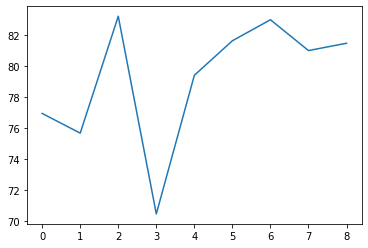

In [98]:
plt.plot(median_freq_data)

plt.show()

In [58]:
bsnb.emg_parameters(signal, fs, raw_to_mv=False)

{'Number of Muscular Activations': 9,
 'Maximum Muscular Activation Duration': 1.3460471982607487,
 'Minimum Muscular Activation Duration': 0.6010210744091449,
 'Average Muscular Activation Duration': 0.9090318746055124,
 'Standard Deviation of Muscular Activation Duration': 0.22846855960280285,
 'Maximum Sample Value': 0.478729248046875,
 'Minimum Sample Value': -0.910400390625,
 'Average Sample Value': 0.0016734834397682248,
 'Standard Deviation Sample Value': 0.06294409866652229,
 'RMS': 0.06296634103839979,
 'Area': 47.72003173828125,
 'Total Power Spect': 0.0038750259945056083,
 'Median Frequency': 82.03125,
 'Maximum Power Frequency': 70.3125}